### Importações e variáveis globais

#### Libs

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from functools import reduce
import re

In [2]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

matplotlib.rcParams['figure.figsize'] = 16,8

#### Globais

In [3]:
global surface_names, epw_columns, snames_hf, snames_hs, mes, meses, casos, area, freq, zonas, eixoy, inic

surfaces_names = ('PERIMETER_TOP_PLENUM_WALL_NORTH','PERIMETER_TOP_PLENUM_WALL_EAST',
'PERIMETER_TOP_PLENUM_WALL_SOUTH','PERIMETER_TOP_PLENUM_WALL_WEST','BUILDING_ROOF',
'PERIMETER_MID_PLENUM_WALL_NORTH','PERIMETER_MID_PLENUM_WALL_EAST','PERIMETER_MID_PLENUM_WALL_SOUTH',
'PERIMETER_MID_PLENUM_WALL_WEST','PERIMETER_BOT_PLENUM_WALL_NORTH','PERIMETER_BOT_PLENUM_WALL_EAST',
'PERIMETER_BOT_PLENUM_WALL_SOUTH','PERIMETER_BOT_PLENUM_WALL_WEST','PERIMETER_TOP_ZN_3_WALL_NORTH',
'PERIMETER_TOP_ZN_2_WALL_EAST','PERIMETER_TOP_ZN_1_WALL_SOUTH','PERIMETER_TOP_ZN_4_WALL_WEST',
'PERIMETER_BOT_ZN_3_WALL_NORTH','PERIMETER_BOT_ZN_2_WALL_EAST','PERIMETER_BOT_ZN_1_WALL_SOUTH',
'PERIMETER_BOT_ZN_4_WALL_WEST','PERIMETER_MID_ZN_3_WALL_NORTH', 'PERIMETER_MID_ZN_2_WALL_EAST',
'PERIMETER_MID_ZN_1_WALL_SOUTH','PERIMETER_MID_ZN_4_WALL_WEST')

epw_columns = ('Year','Month','Day','Hour','Minute','Source',
'DBT [°C]','DPT [°C]','RU [%]','AtmPa [Pa]','ETGlbHrz [Wh/m²]', 'ETdirNrm [Wh/m²]', 
'InfraRed [Wh/m²]', 'GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'DifHrz [Wh/m²]',
'LuxGlbHrz [lux]', 'LuxDirNrm [lux]', 'LuxDifHrz [lux]', 'LuxZenit [lux]', 
'DirWind [°]', 'DirSpeed [m/s]', 'Nebul', 'Opac', 'Visib [km]', 'Height [m]', 'Obs', 'Code',
'Precp [mm]', 'Aerosol', 'SnowDepth [cm]', 'SinceSnow', 'Albedo ', 'PrecDep [mm]', 'PrepTax [h]')

snames_hf = []
snames_hs = []

for item in surfaces_names:
    snames_hf.append(item + ':Surface Average Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')
    snames_hs.append(item + ':Surface Heat Storage Rate per Area [W/m2](Hourly)')

snames_hf = tuple(snames_hf)
snames_hs = tuple(snames_hs)

mes = ('Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez')

inic = [x[0] for x in mes]

meses = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun', 
        7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}

casos = {'ISO': 'Isolante Térmico', 'PCM': 'Material de Mudança de Fase', 'VAZ': 'Nenhum Material'}

freq = {'H': 'Horária', 'D': 'Diária', 'W': 'Semanal', 'M': 'Mensal', 'Y': 'Anual'}

zonas = {'MID_ZN_1': 'Zona Térmica 1 (Fachada Sul)', 'MID_ZN_3': 'Zona Térmica 3 (Fachada Norte)', 'TOP': 'Plenum'}

climas_def = {'2020':'TMYx', '2050':'Projeção 2050', '2080':'Projeção 2080'}

eixoy = {}

area = 4982.19 # m²

### Funções e classes

#### Funções

In [4]:
def renomear(name):
    def corte(name):
        s = re.split(r'[:_]',name)
        return s[-2]

    if 'Conduction' in name:
        return (f'Fluxo de calor por condução {corte(name)} [W/m²]')
    elif 'Storage' in name:
        return (f'Taxa de calor armazenado {corte(name)} [W/m²]')
    elif 'Radiant' in name:
        return 'Temperatura Média Radiante [°C]'
    elif 'Operative' in name:
        return 'Temperatura Operativa [°C]'
    elif 'Load' in name:
        return 'Carga térmica sensível até setpoint [W]'


def dicionario(df_list):
    """
    Cria um dicionário de dataframes com os anos como chave.
    """

    df_dict = {}
    for key, df in enumerate(df_list):
        year = df.index.year[0]
        df_dict[key] = df
        df_dict[year] = df_dict.pop(key)

    return df_dict


def comparar_climas(climate_list):
    dummy = climate_list.copy()
    df = pd.DataFrame()

    for climate in dummy:
        climate[0].index = pd.date_range(start=f'1/1/2000', periods=len(climate[0]), freq='M')
        df[climas_def[climate[1]]] = climate[0]
    
    df['Mês'] = df.index.month
    df['Mês'] = df['Mês'].map(meses)

    df.plot(x = 'Mês', title = f'Temperatura de Bulbo Seco Externa - Média Mensal',
            figsize=(16,8), ylabel = 'Temperatura [°C]', grid='both')

    plt.xticks(np.arange(12), labels = mes);

    return df


def comparar_anos(zone_list, var, resample=False, how=None):
    """
    Cria um dicionário com os parâmetros que deseja-se comparar entre as aplicações nos mesmos anos. 
    """

    dummy = zone_list.copy()
    df = pd.DataFrame()

    for zone in dummy:
        zone[0][var].index = pd.date_range(start=f'1/1/2000', periods=len(zone[0][var]), freq='H')
        df[zone[1][2]] = zone[0][var]

    if resample != None and how != None:
        df.resample(how).mean().plot(title = f'{zonas[dummy[0][2]]} - {var}\nZona Climática {dummy[0][1][0]}',
                                     figsize=(16,8), ylabel = f'{var} - Média {freq[how]}', grid='both')
    else:
        df.plot(title = f'{zonas[dummy[0][2]]} - {var}Zona Climática {dummy[0][1][0]}', 
                figsize=(16,8), ylabel = var, grid='both')

    return df


def comparar_casos(zone_list, var, resample = False, how = None, trunc = False, before = None, after = None):
    """
    Cria um dicionário com os parâmetros que deseja-se comparar entre as aplicações nos mesmos anos. 
    """

    dummy = zone_list.copy()
    df = pd.DataFrame()
    difs = pd.DataFrame()

    for zone in dummy:
        df[casos[zone[1][1]]] = zone[0][var]
    
    if trunc != False and before != None and after != None:
        df = df.truncate(before = before, after = after)
        difs = difs.truncate(before = before, after = after)
    else:
        pass

    if resample != None and how != None:
        df.resample(how).median().plot(title = f'{zonas[dummy[0][2]]} - {var}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                                        figsize=(16,8), ylabel = f'{var} - Média {freq[how]}', grid='both')
    else:
        df.plot(title = f'{zonas[dummy[0][2]]} - {var}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                figsize=(16,8), ylabel = var, grid='both')

    return df, difs


def comparar_consumo(consumos):
    dummy = consumos.copy()
    df2020 = pd.DataFrame()
    df2050 = pd.DataFrame()
    df2080 = pd.DataFrame()

    dfs = {2020: df2020, 2050: df2050, 2080: df2080}

    for consumo in dummy:
        if consumo[1][2] == '2020':
            dfs[int(consumo[1][2])][casos[consumo[1][1]]] = consumo[0]['Energia Elétrica [kWh]']
        elif consumo[1][2] == '2050':
            dfs[int(consumo[1][2])][casos[consumo[1][1]]] = consumo[0]['Energia Elétrica [kWh]']
        elif consumo[1][2] == '2080':
            dfs[int(consumo[1][2])][casos[consumo[1][1]]] = consumo[0]['Energia Elétrica [kWh]']


    fig, axs = plt.subplots(1,3)
    aux = 0

    for key,df in dfs.items():
        df['Mês'] = df.index.month
        df['Mês'] = df['Mês'].map(meses)
        df.plot(x='Mês', title = f'Ano Referência {key}',grid = 'both', ax = axs[aux], legend = False);
        axs[aux].set_xticks(range(12));
        axs[aux].set_xticklabels(inic);

        axs[aux].set_yticks(np.arange(5000, 45000, 5000))
        aux += 1
        
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    fig.supylabel(x = 0.07, t = 'Energia [kWh]')
    fig.suptitle(t = 'Energia Consumida para Climatização', va = 'center', fontsize=25)
    fig.legend(casos.values(), loc='lower center', ncol=len(casos.values()), bbox_to_anchor=(0.5,-0.05), fontsize=18);
    fig.set_figheight(8)
    fig.set_figwidth(20)


#TODO 
def plotar_zona(zona_termica):
    """
    Plot de um dataframe com várias colunas ou apenas uma das colunas de interesse.
    """
    axes = zona_termica[0].resample('D').mean().plot(figsize=(15,30), subplots=True, legend = False, grid='both');
    plt.subplots_adjust(hspace=0.35)
    print("-".join(zona_termica[1]))

    for plots in axes:
        plots.set_title(zona_termica[0].columns[list(axes).index(plots)]);

    

#### Classe

In [5]:
class database:
    """
    Classe para base de dados dos resultados das simulações.
    """
    def __init__(self, path):
        df = pd.read_csv(path, sep = ',')

        def splitar(name, pos):
            s = name.split('/')
            s0 = re.split(r'[-.]',s[-1])
            return s0[pos]

        clzone = splitar(path, 0)
        case = splitar(path, 1)
        year = splitar(path, 2)

        self.app = (clzone, case, year)

        ## Modifica a coluna de índice
        df = df.drop(columns = ['Date/Time'])
        df.index = pd.date_range(start=f'1/1/{self.app[-1]}', periods=len(df), freq='H')
        df.index.name = 'Date/Time'

        self.df = df.copy()

        ## Cria subdataframes de acordo com as propriedades de interesse

        # Temperatura de bulbo seco do exterior
        self.dbt = df.copy().loc[:,'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)']
        
        # Fluxo de calor por condução na superfície
        self.heat_flux = df.copy().loc[:, 
            df.columns.str.endswith('Surface Average Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')]
        self.heat_flux = self.heat_flux[[col for col in self.heat_flux.columns if col in snames_hf]]

        # Calor armazenado na superfície
        self.heat_stg = df.copy().loc[:, 
            df.columns.str.endswith('Surface Heat Storage Rate per Area [W/m2](Hourly)')]
        self.heat_stg = self.heat_stg[[col for col in self.heat_stg.columns if col in snames_hs]]
        
        # Temperatura Média Radiante da Zona (mean radiant temperature)
        self.mrt = df.copy().loc[:, 
            df.columns.str.endswith('Zone Mean Radiant Temperature [C](Hourly)')]
        
        # Temperatura Média do Ar da Zona (mean air temperature)
        self.top = df.copy().loc[:, 
            df.columns.str.endswith('Zone Operative Temperature [C](Hourly)')]
        
        # Carga térmica sensível até o setpoint
        self.load = df.copy().loc[:, 
            df.columns.str.contains('Load')]

        # Consumo de energia com HVAC
      
        data_frames = [self.dbt, self.heat_flux, self.heat_stg, self.mrt, self.top, self.load]

        self.df_filter = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), data_frames)


    def outputs(self):
        print(f"É possível solicitar as informações das superfícies e zonas térmicas:\n\n{surfaces_names}")

  
    def clima(self):
        """
        Gera um dataframe com as médias mensais da temperatura de bulbo seco.
        """
        df = self.dbt.copy().resample('M').mean()

        return df, self.app[-1]


    def zone(self, zona_termica):
        """
        Extrai os outputs de uma zona térmica específica.
        """
        if zona_termica in ('TOP', 'MID', 'BOT'):
            df1 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains(zona_termica+'_PLENUM'))]
            df2 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains(zona_termica+'FLOOR'))]
            df3 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.startswith('BUILDING_ROOF'))]
            df4 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains('FIRSTFLOOR'))]

            if zona_termica == 'TOP':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df2,df3])
            elif zona_termica == 'MID':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df2])
            elif zona_termica == 'BOT':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df4])
                                            
        else:
            df = self.df_filter.copy().loc[:, 
                self.df_filter.columns.str.contains(zona_termica)]
    
        df.columns = map(renomear, df.columns)

        return df, self.app, zona_termica


    def hvac(self):
        df = (self.df.copy().loc[:, 
           self.df.columns.str.contains('HVAC')])/(3600E3)
        df.columns = ("Gás Natural [kWh]", "Energia Elétrica [kWh]")
        df = df.resample('M').sum()

        return df, self.app


class climate:
    def __init__(self, file, year):
        self.df_epw = pd.read_csv(file, names=epw_columns)
        self.df_epw = self.df_epw.drop(columns = ['Year','Month','Day','Hour','Minute'])
        self.df_epw.index = pd.date_range(start=f'1/1/{str(year)}', periods=len(self.df_epw), freq='H')

        self.df = self.df_epw.drop(columns=['Source','RU [%]','AtmPa [Pa]','ETGlbHrz [Wh/m²]', 'ETdirNrm [Wh/m²]', 
        'LuxGlbHrz [lux]', 'LuxDirNrm [lux]', 'LuxDifHrz [lux]', 'LuxZenit [lux]', 'DirWind [°]',
        'DirSpeed [m/s]', 'Nebul', 'Opac', 'Visib [km]', 'Height [m]', 'Obs', 'Code',
        'Precp [mm]', 'Aerosol', 'SnowDepth [cm]', 'SinceSnow', 'Albedo ', 'PrecDep [mm]', 'PrepTax [h]'])




### Execução

#### 2A

##### Lendo csv

In [6]:
pcm_2020_2a = database('outputs/2A/TMYx/2A-PCM-2020.csv')
pcm_2050_2a = database('outputs/2A/TMYx/2A-PCM-2050.csv')
pcm_2080_2a = database('outputs/2A/TMYx/2A-PCM-2080.csv')

iso_2020_2a = database('outputs/2A/TMYx/2A-ISO-2020.csv')
iso_2050_2a = database('outputs/2A/TMYx/2A-ISO-2050.csv')
iso_2080_2a = database('outputs/2A/TMYx/2A-ISO-2080.csv')

vaz_2020_2a = database('outputs/2A/TMYx/2A-VAZ-2020.csv')
vaz_2050_2a = database('outputs/2A/TMYx/2A-VAZ-2050.csv')
vaz_2080_2a = database('outputs/2A/TMYx/2A-VAZ-2080.csv')

In [7]:
climas = [iso_2020_2a.clima(),
          iso_2050_2a.clima(),
          iso_2080_2a.clima()]

consumos = [iso_2020_2a.hvac(),
            iso_2050_2a.hvac(),
            iso_2080_2a.hvac(),
            
            pcm_2020_2a.hvac(),
            pcm_2050_2a.hvac(),
            pcm_2080_2a.hvac(),
            
            vaz_2020_2a.hvac(),
            vaz_2050_2a.hvac(),
            vaz_2080_2a.hvac()]

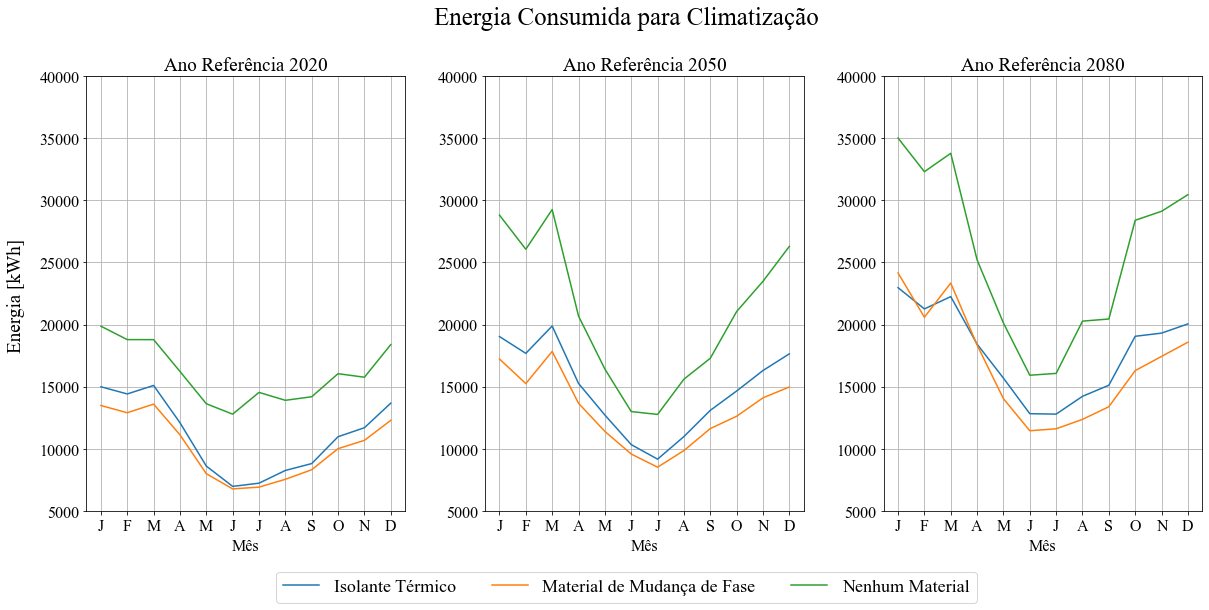

In [54]:
comparar_consumo(consumos)

In [290]:
dummy = consumos.copy()
df = pd.DataFrame()

for consumo in dummy:
    consumo[0].index = pd.date_range(start=f'1/1/2000', periods=len(consumo[0]), freq='H')
    df[casos[consumo[1][1]]+'-'+consumo[1][2]] = consumo[0]['Energia Elétrica [kWh]']
    df['Mes'] = df.index.month
    df['Mes'] = df['Mes'].map(meses)
    
df = df.reset_index()
df = df.drop(columns = 'index')
df = df.melt(id_vars = 'Mes')

lista_casos = df['variable'].to_list()

anos = []
caso_lst = []
dummy_casos = pd.DataFrame()

for caso in lista_casos:
    anos.append(caso.split("-")[1])
    caso_lst.append(caso.split("-")[0])

dummy_casos['Anos'] = anos
dummy_casos['Caso'] = caso_lst

df = pd.concat([dummy_casos, df], axis = 1)

df.head()
#sns.lineplot(data = df)

,Anos,Caso,Mes,variable,value
0,2020,Isolante Térmico,Jan,Isolante Térmico-2020,14999.700947
1,2020,Isolante Térmico,Jan,Isolante Térmico-2020,14419.866198
2,2020,Isolante Térmico,Jan,Isolante Térmico-2020,15103.408366
3,2020,Isolante Térmico,Jan,Isolante Térmico-2020,12106.938487
4,2020,Isolante Térmico,Jan,Isolante Térmico-2020,8616.790815


##### Gerando objetos de zonas (zona 1, zona 3 e plenum)

In [8]:
ZN3_pcm2020 = pcm_2020_2a.zone('MID_ZN_3')
ZN3_pcm2050 = pcm_2050_2a.zone('MID_ZN_3')
ZN3_pcm2080 = pcm_2080_2a.zone('MID_ZN_3')

ZN1_pcm2020 = pcm_2020_2a.zone('MID_ZN_1')
ZN1_pcm2050 = pcm_2050_2a.zone('MID_ZN_1')
ZN1_pcm2080 = pcm_2080_2a.zone('MID_ZN_1')

ZN3_iso2020 = iso_2020_2a.zone('MID_ZN_3')
ZN3_iso2050 = iso_2050_2a.zone('MID_ZN_3')
ZN3_iso2080 = iso_2080_2a.zone('MID_ZN_3')

ZN1_iso2020 = iso_2020_2a.zone('MID_ZN_1')
ZN1_iso2050 = iso_2050_2a.zone('MID_ZN_1')
ZN1_iso2080 = iso_2080_2a.zone('MID_ZN_1')

ZN3_vaz2020 = vaz_2020_2a.zone('MID_ZN_3')
ZN3_vaz2050 = vaz_2050_2a.zone('MID_ZN_3')
ZN3_vaz2080 = vaz_2080_2a.zone('MID_ZN_3')

ZN1_vaz2020 = vaz_2020_2a.zone('MID_ZN_1')
ZN1_vaz2050 = vaz_2050_2a.zone('MID_ZN_1')
ZN1_vaz2080 = vaz_2080_2a.zone('MID_ZN_1')

ZN3_2020 = [ZN3_iso2020, ZN3_pcm2020, ZN3_vaz2020]
ZN1_2020 = [ZN1_iso2020, ZN1_pcm2020, ZN1_vaz2020]

plenum_pcm2020 = pcm_2020_2a.zone('TOP')
plenum_iso2020 = iso_2020_2a.zone('TOP')
plenum_vaz2020 = vaz_2020_2a.zone('TOP')

plenum_2020 = [plenum_pcm2020, plenum_iso2020, plenum_vaz2020]

##### Plots

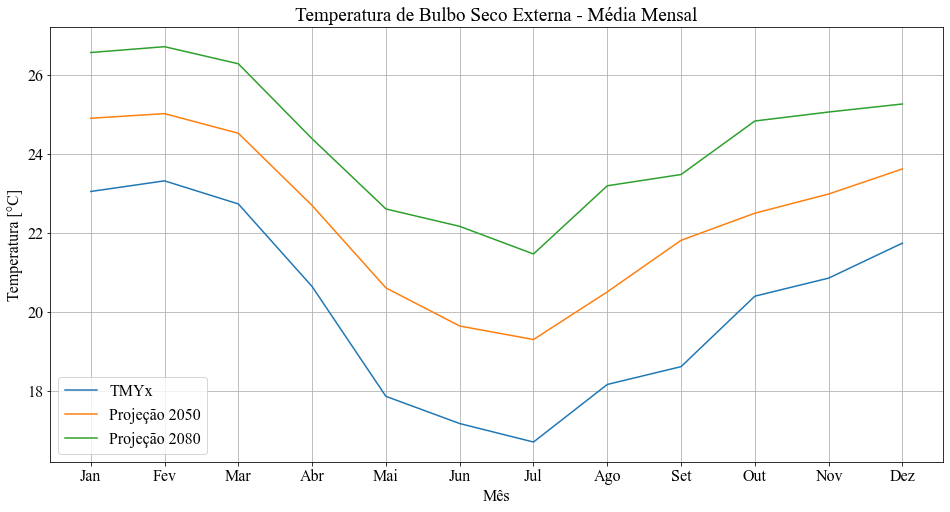

In [9]:
comparar_climas(climate_list=climas);

In [88]:
ZN3_2020[0][0].columns

Index(['Fluxo de calor por condução NORTH [W/m²]',
       'Taxa de calor armazenado NORTH [W/m²]',
       'Temperatura Média Radiante [°C]', 'Temperatura Operativa [°C]',
       'Carga térmica sensível até setpoint [W]'],
      dtype='object')

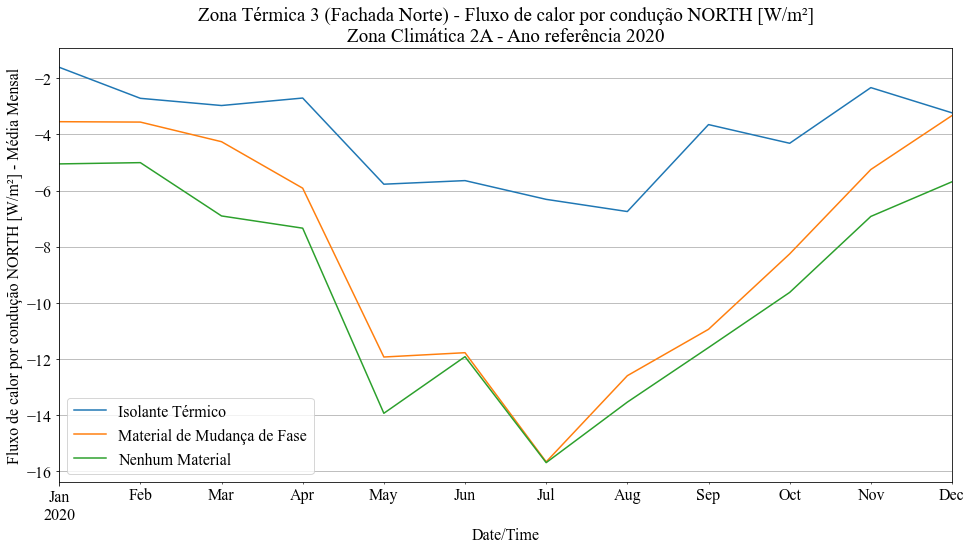

In [16]:
comparar_casos(zone_list = ZN3_2020, var = 'Fluxo de calor por condução NORTH [W/m²]', 
                resample = True, how = 'M', trunc = False, before = '2020-01-01', after = '2020-01-31');

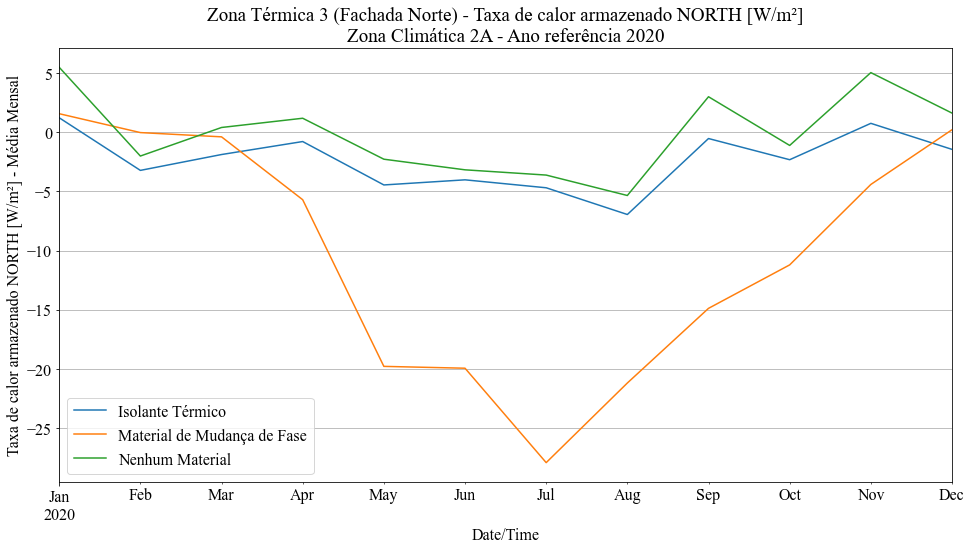

In [17]:
comparar_casos(zone_list = ZN3_2020, var = 'Taxa de calor armazenado NORTH [W/m²]', 
                resample = True, how = 'M', trunc = False, before = '2020-01-01', after = '2020-01-02');

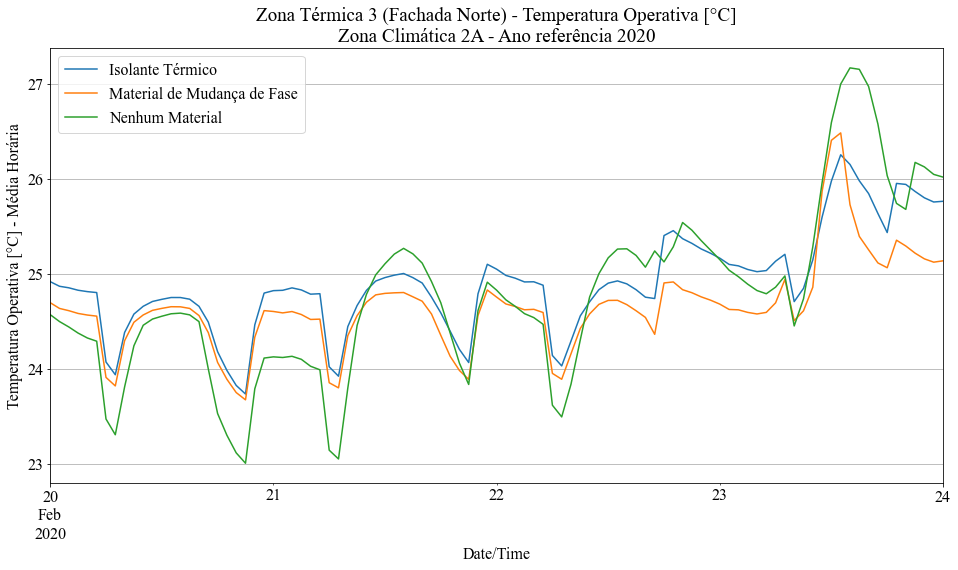

In [20]:
comparar_casos(zone_list = ZN3_2020, var = 'Temperatura Operativa [°C]', 
                resample = False, how = 'H', trunc = True, before = '2020-02-20', after = '2020-02-24');

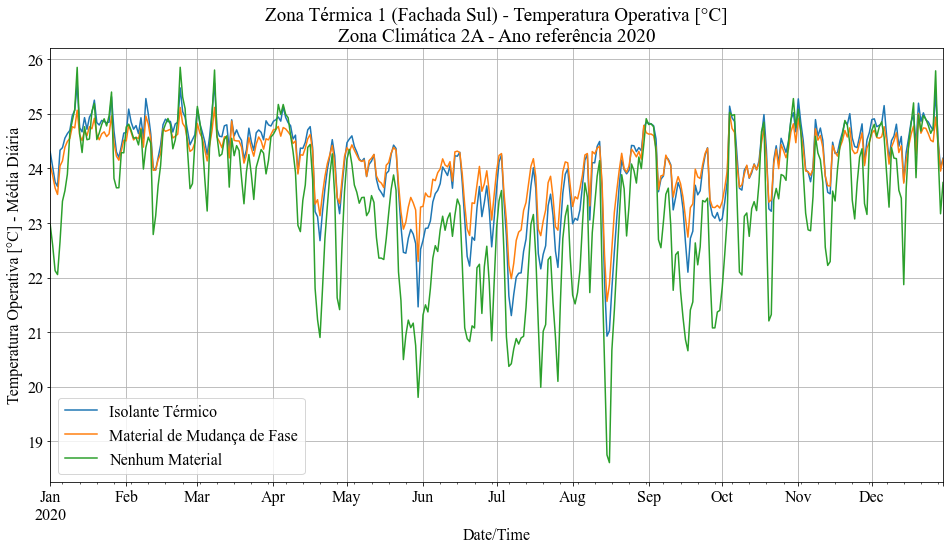

In [59]:
comparar_casos(zone_list = ZN1_2020, var = 'Temperatura Operativa [°C]', 
                resample = True, how = 'D', trunc = False, before = '2020-01-01', after = '2020-01-31');

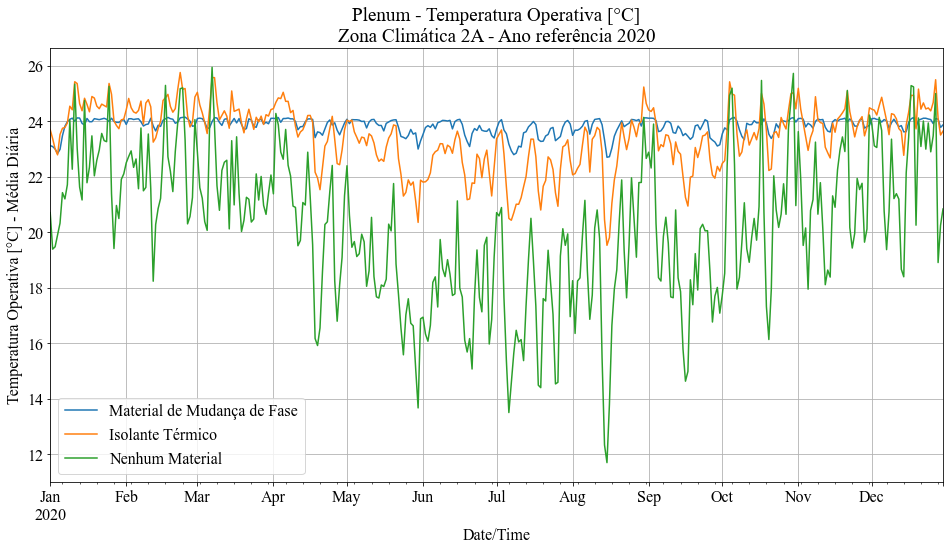

In [58]:
comparar_casos(zone_list = plenum_2020, var = 'Temperatura Operativa [°C]', 
                resample = True, how = 'D', trunc = False, before = '2020-01-01', after = '2020-01-31');

### Plots

2A-PCM-2020


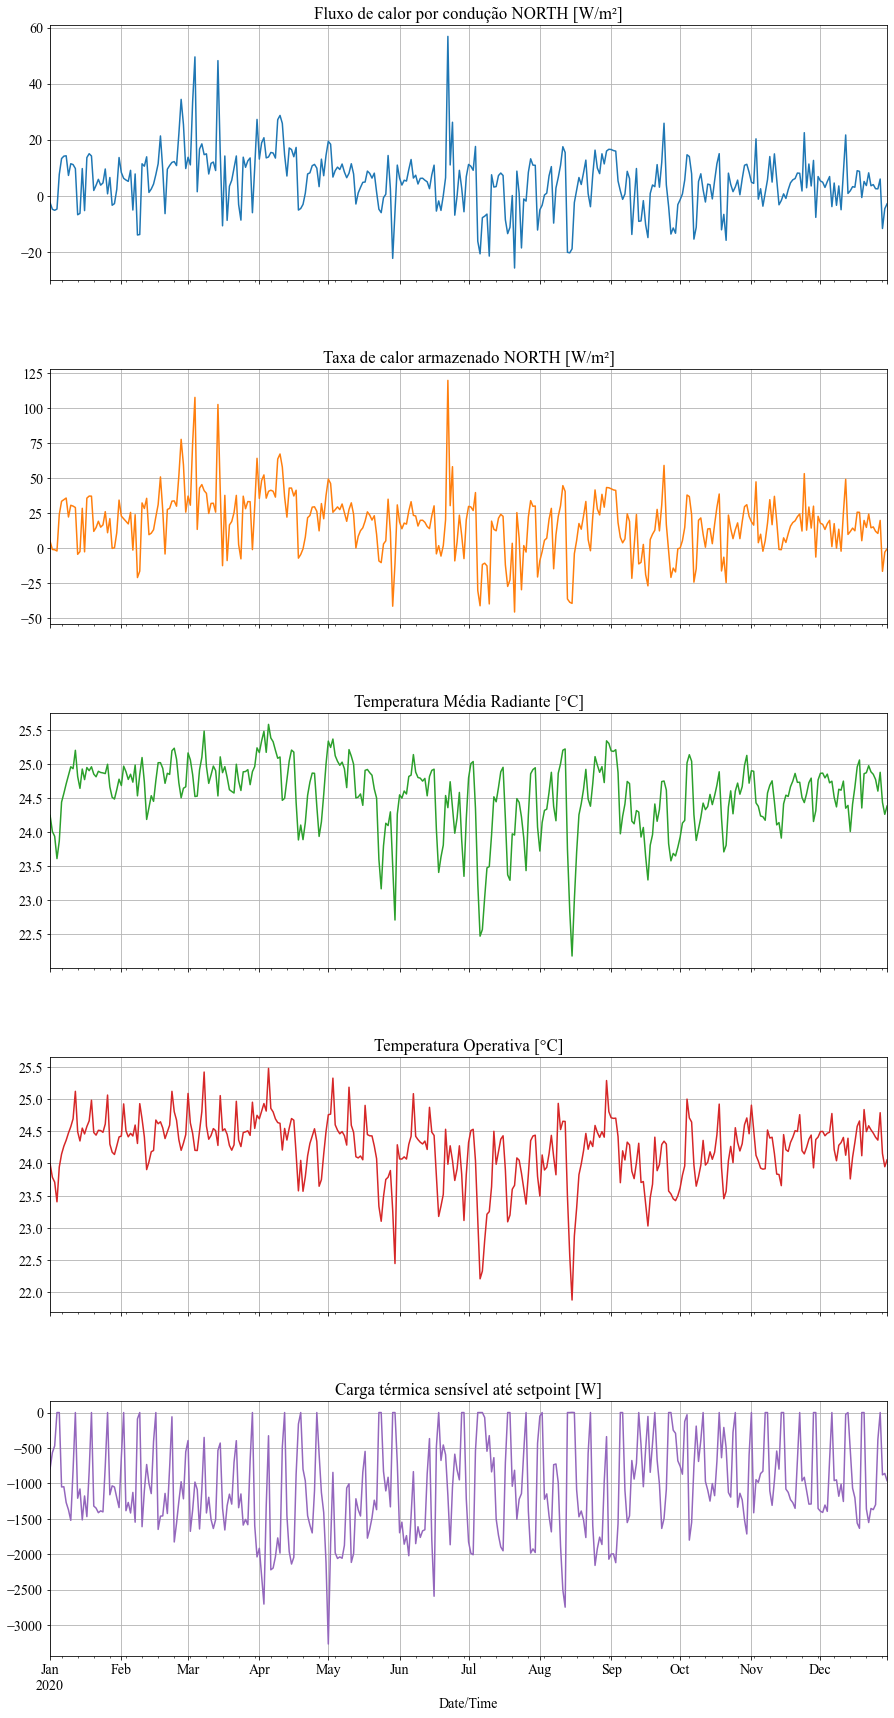

In [84]:
plotar_zona(ZN3_pcm2020)

### Testes epw

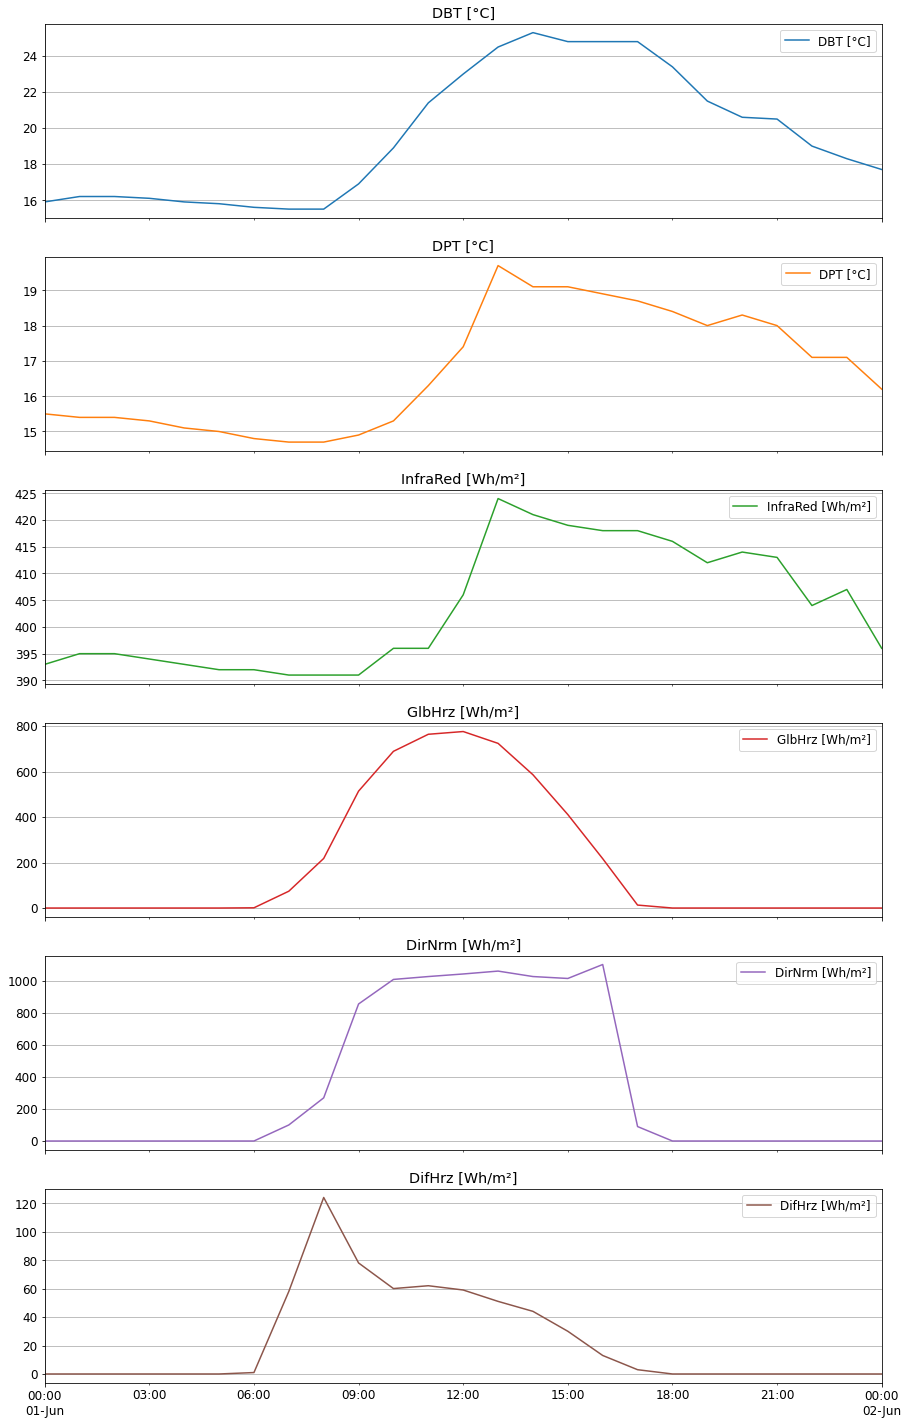

In [224]:
sp2020 = climate('climaticos/BRA_Sao Paulo-Congonhas AP_HadCM3-A2-2020.csv', 2020)

axes = sp2020.df.truncate(before='2020-06-01', after='2020-06-02').plot(figsize=(15,25), 
                    subplots=True, grid = 'both');

for plots in axes:
    plots.set_title(sp2020.df.columns[list(axes).index(plots)])

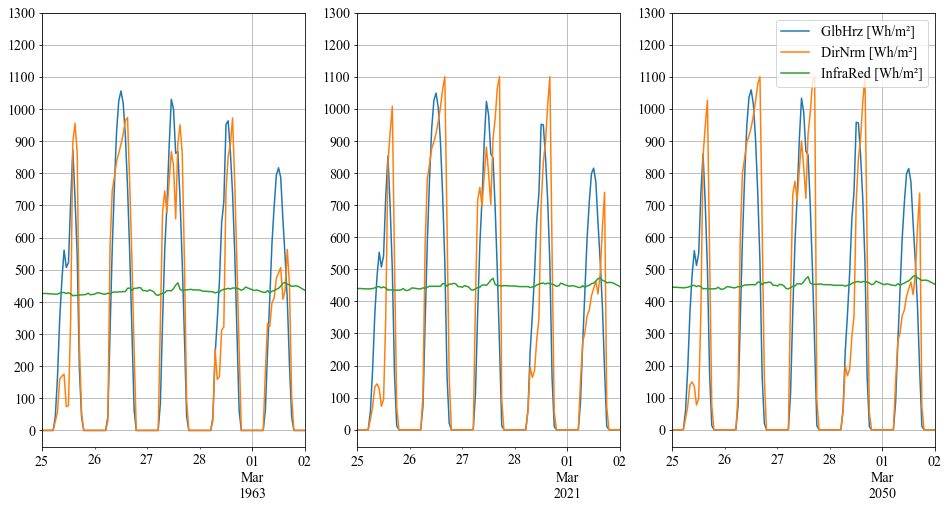

In [45]:
rj2020 = climate('climaticos\Rio-de-Janeiro-2020.csv', 2021)
rj2050 = climate('climaticos\Rio-de-Janeiro-2050.csv', 2050)
rj1963 = climate('climaticos/BRA_RJ_Rio.de.Janeiro-Galeao-Jobim.Intl.AP.837460_TRY.1963.csv', 1963)

data20 = rj2020.df.truncate(before='2021-02-25', after='2021-03-02')
data50 = rj2050.df.truncate(before='2050-02-25', after='2050-03-02')
data63 = rj1963.df.truncate(before='1963-02-25', after='1963-03-02')

fig, (ax, ax2, ax3) = plt.subplots(ncols = 3)

data20.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax2, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data50.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax3, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data63.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax, 
           figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)

plt.legend(['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'])
plt.show()

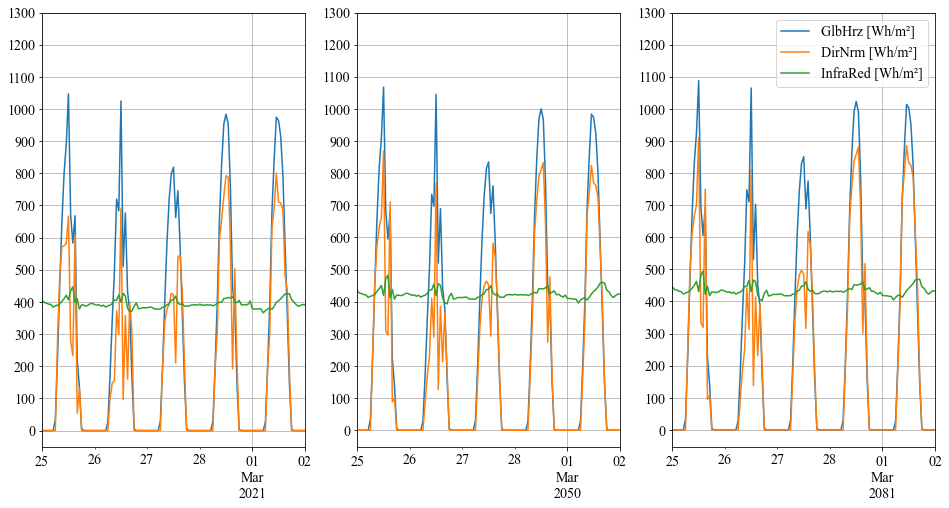

In [10]:
sp2020_tmyx = climate('climaticos/TMYx/BRA_SP_Sao.Paulo-Congonhas.AP.837800_TMYx.csv', 2021)
sp2050 = climate('climaticos/TMYx/BRA_Sao Paulo Congonhas AP_HadCM3-A2-2050.csv', 2050)
sp2080 = climate('climaticos/TMYx/BRA_Sao Paulo Congonhas AP_HadCM3-A2-2080.csv', 2081)

tmyx = sp2020_tmyx.df.truncate(before='2021-02-25', after='2021-03-02')
data50 = sp2050.df.truncate(before='2050-02-25', after='2050-03-02')
data80 = sp2080.df.truncate(before='2081-02-25', after='2081-03-02')

fig, (ax, ax2, ax3) = plt.subplots(ncols = 3)

tmyx.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data50.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax2, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data80.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax3, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)

plt.legend(['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'])
plt.show()

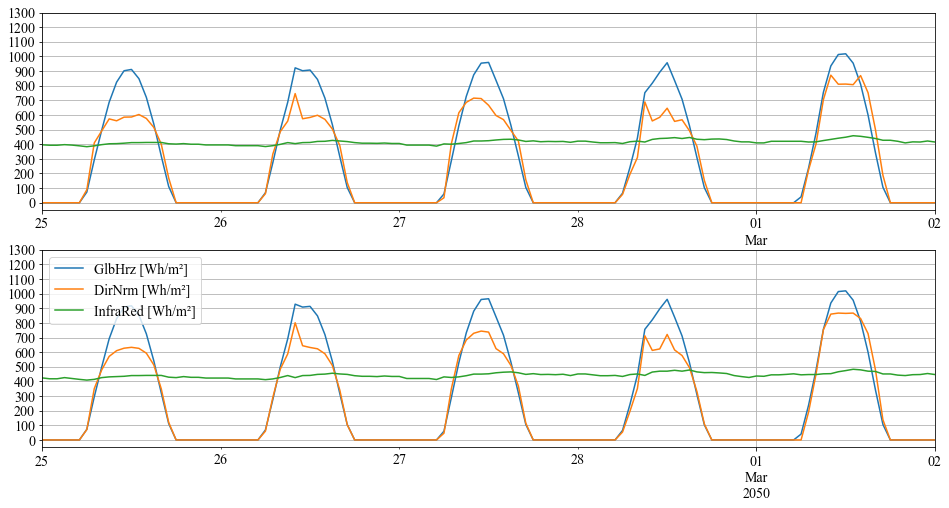

In [49]:
rj2020_tmyx = climate('climaticos\TMYx\RJ\BRA_RJ_Rio.de.Janeiro-Santos.Dumont.AP.837550_TMYx.csv', 2021)
rj2050_tmyx = climate('climaticos\TMYx\RJ\BRA_Rio de Janeiro Santos Dumont AP_HadCM3-A2-2050.csv', 2050)

data20_tmyx = rj2020_tmyx.df.truncate(before='2021-02-25', after='2021-03-25')
data50_tmyx = rj2050_tmyx.df.truncate(before='2050-02-25', after='2050-03-25')

fig, (ax, ax2) = plt.subplots(2)

data20_tmyx.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data50_tmyx.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax2, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)

plt.legend(['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'])
plt.show()

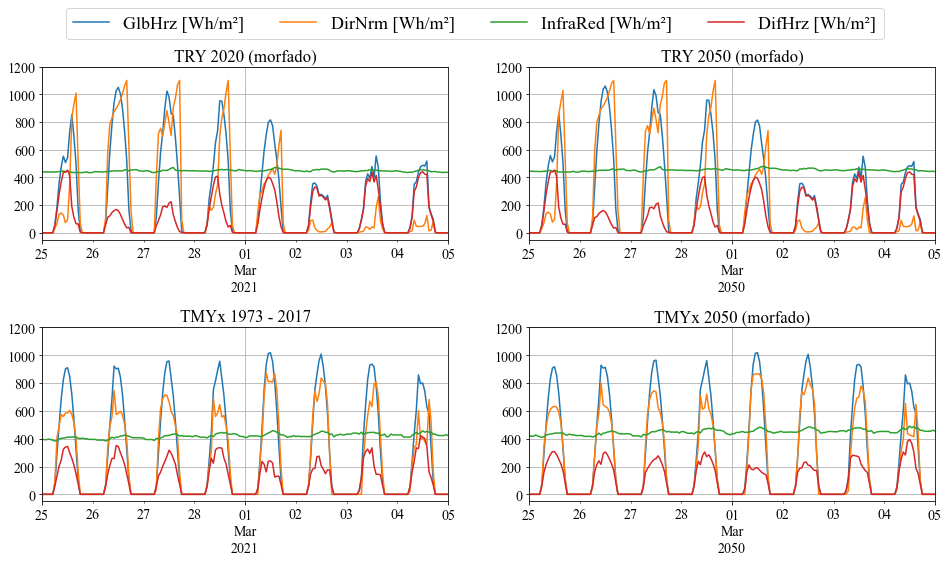

In [60]:
data20 = rj2020.df.truncate(before='2021-02-25', after='2021-03-05')
data50 = rj2050.df.truncate(before='2050-02-25', after='2050-03-05')
data20_tmyx = rj2020_tmyx.df.truncate(before='2021-02-25', after='2021-03-05')
data50_tmyx = rj2050_tmyx.df.truncate(before='2050-02-25', after='2050-03-05')

labels = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]', 'DifHrz [Wh/m²]']

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,8))

data20.plot(y = labels, ax=ax, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax.set_title('TRY 2020 (morfado)')

data50.plot(y = labels, ax=ax2, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax2.set_title('TRY 2050 (morfado)')

data20_tmyx.plot(y = labels, ax=ax3, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax3.set_title('TMYx 1973 - 2017')

data50_tmyx.plot(y = labels, ax=ax4, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax4.set_title('TMYx 2050 (morfado)')

plt.subplots_adjust(hspace=0.5)
fig.legend(labels, loc='upper center', ncol=len(labels), fontsize=18);